# Explore here

In [1]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pickle import dump

In [3]:
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
total_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
total_data = total_data.drop_duplicates().reset_index(drop = True)
total_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
X = total_data.drop("Outcome", axis = 1)
y = total_data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(k = 7)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,84.0,0.0,0.0,0.0,0.304,21.0
1,9.0,112.0,82.0,0.0,28.2,1.282,50.0
2,1.0,139.0,46.0,83.0,28.7,0.654,22.0
3,0.0,161.0,50.0,0.0,21.9,0.254,65.0
4,6.0,134.0,80.0,370.0,46.2,0.238,46.0


In [6]:
X_test_sel.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,98.0,58.0,190.0,34.0,0.430,43.0
1,2.0,112.0,75.0,0.0,35.7,0.148,21.0
2,2.0,108.0,64.0,0.0,30.8,0.158,21.0
3,8.0,107.0,80.0,0.0,24.6,0.856,34.0
4,7.0,136.0,90.0,0.0,29.9,0.210,50.0


In [7]:
X_train_sel["Outcome"] = y_train.values
X_test_sel["Outcome"] = y_test.values
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [8]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

train_data.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.0,84.0,0.0,0.0,0.0,0.304,21.0,0
1,9.0,112.0,82.0,0.0,28.2,1.282,50.0,1
2,1.0,139.0,46.0,83.0,28.7,0.654,22.0,0
3,0.0,161.0,50.0,0.0,21.9,0.254,65.0,0
4,6.0,134.0,80.0,370.0,46.2,0.238,46.0,1


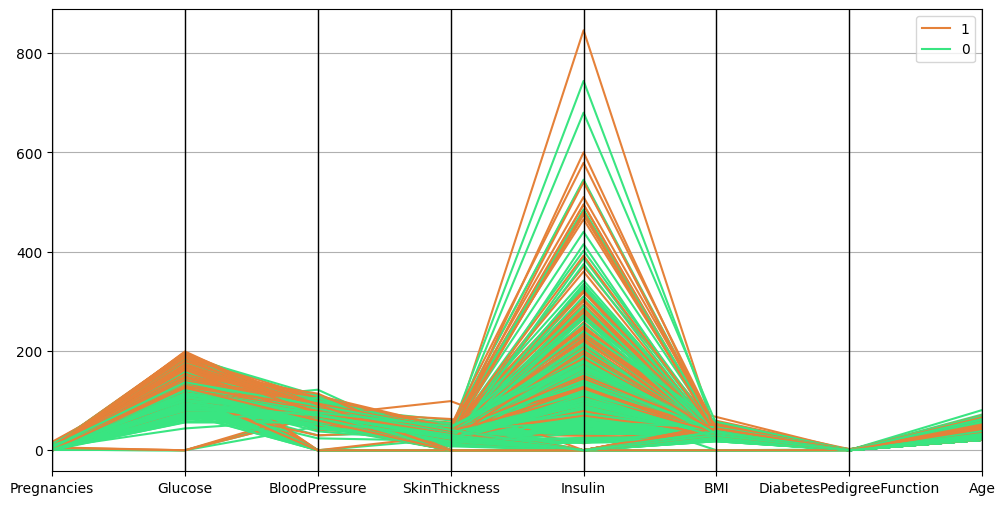

In [9]:
plt.figure(figsize=(12, 6))

pd.plotting.parallel_coordinates(total_data, "Outcome", color = ("#E58139", "#39E581", "#8139E5"))

plt.show()

In [10]:
X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

In [11]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

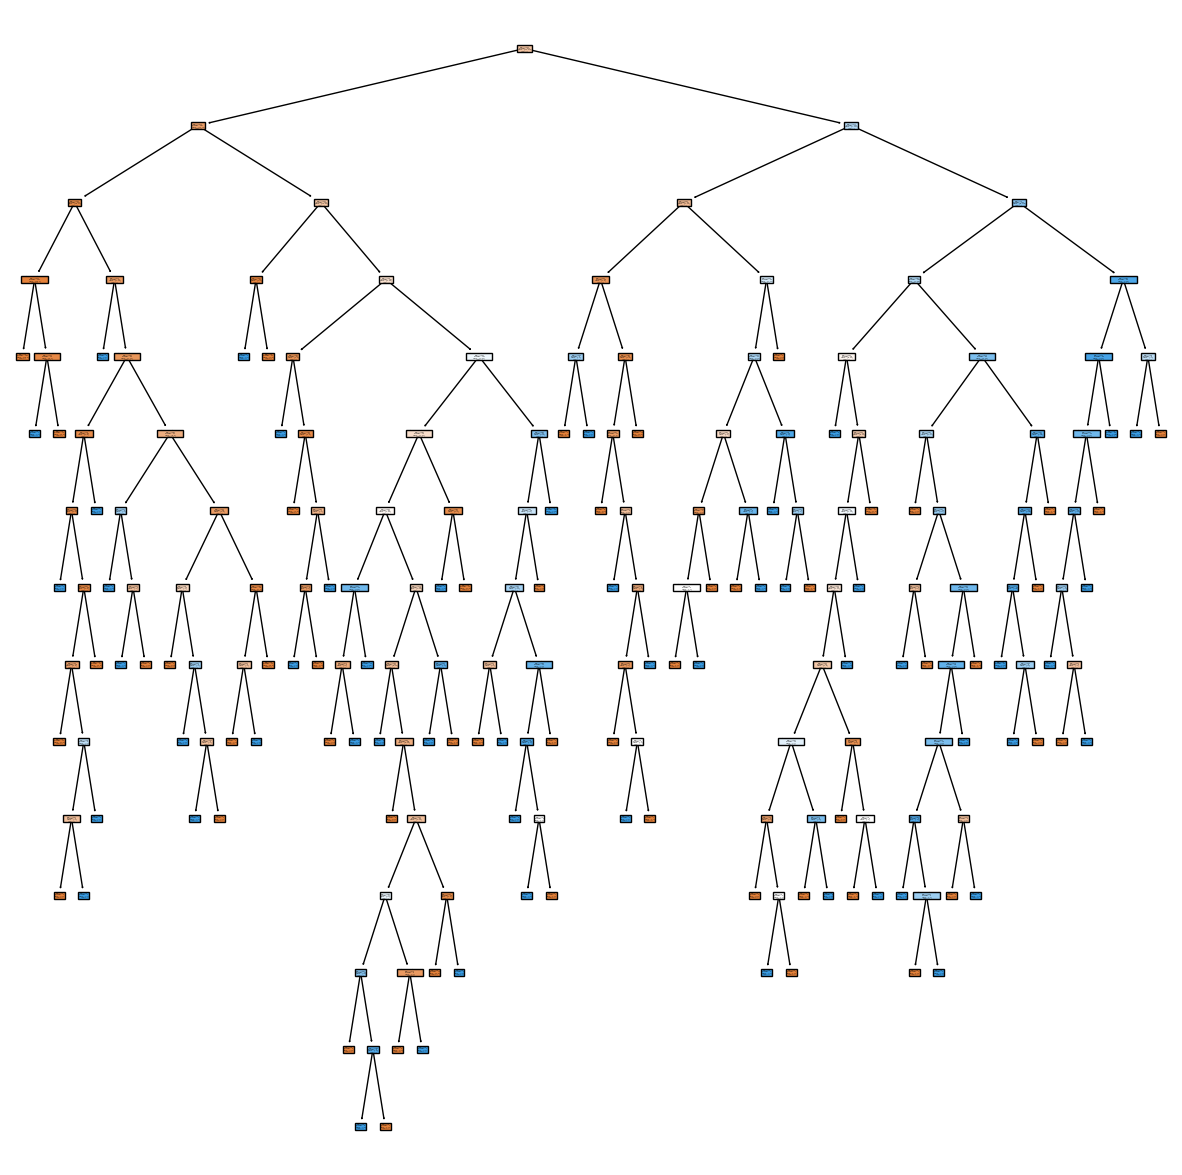

In [12]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()

In [13]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [14]:
accuracy_score(y_test, y_pred)

0.7597402597402597

In [15]:
hyperparams = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)
grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [16]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [17]:
model = DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf = 4, min_samples_split = 2, random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=42)

In [18]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [19]:
accuracy_score(y_test, y_pred)

0.7727272727272727

In [20]:
dump(model, open("../models/tree_classifier_crit-entro_maxdepth-5_minleaf-4_minsplit2_42.sav", "wb"))